In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Wed Jan 24 19:17:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.9999

hp.M = hp.n_prior_embeddings

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform_notconst_1e-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 440475, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

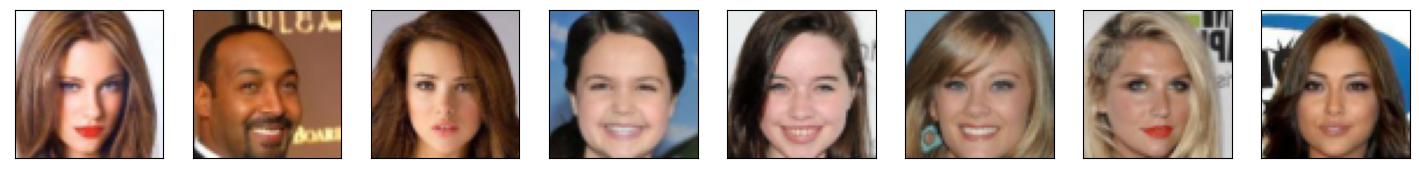

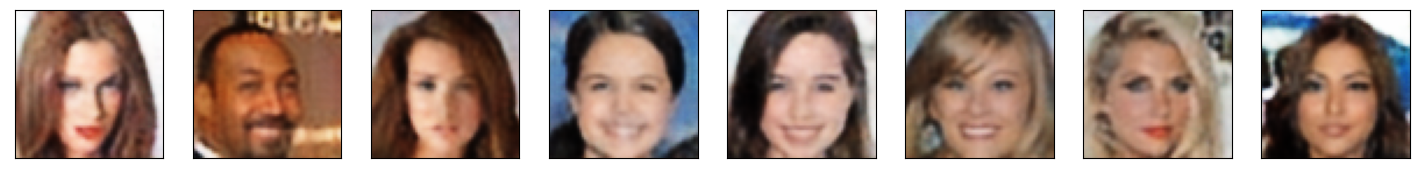

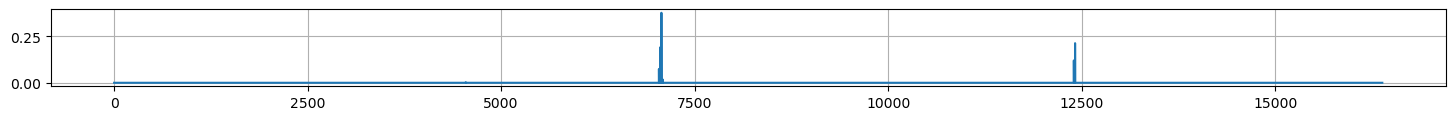

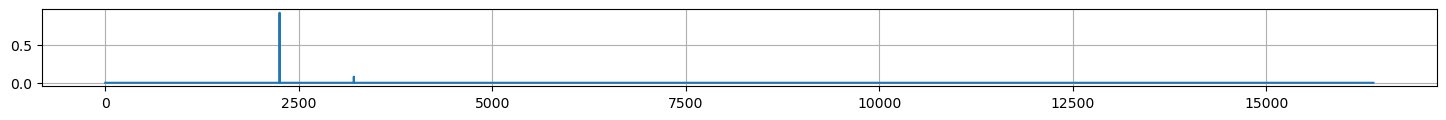

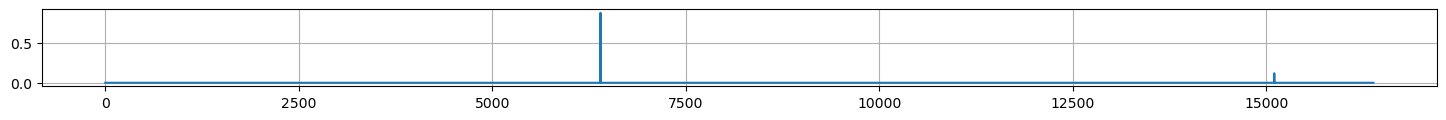

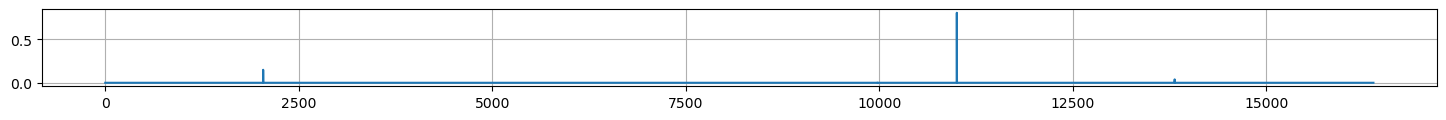

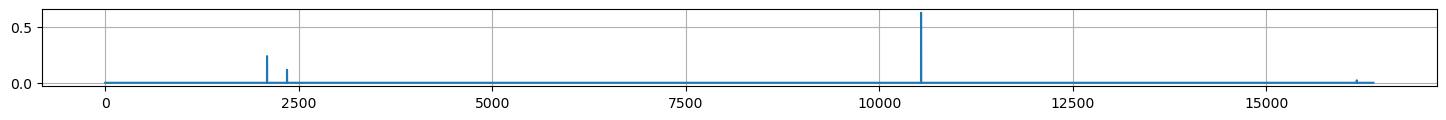

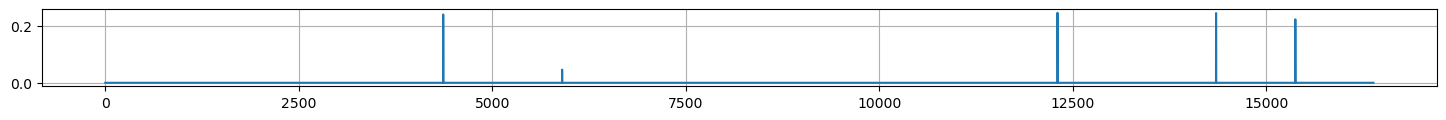

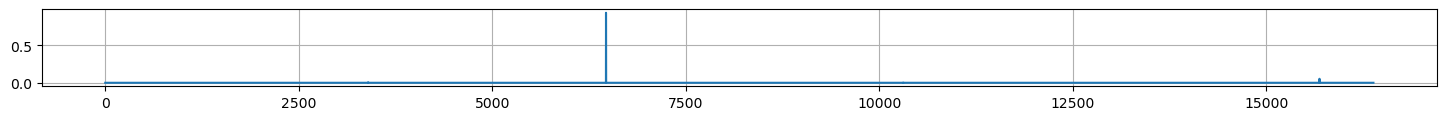

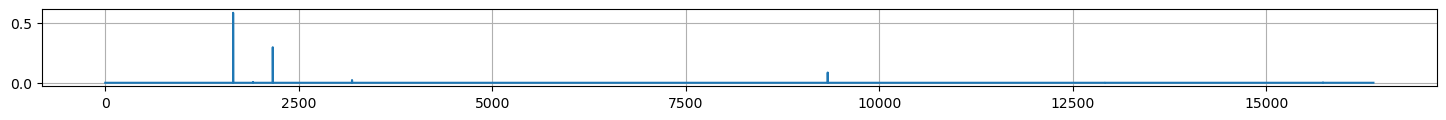

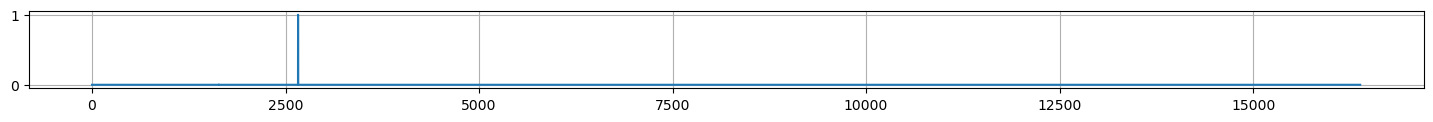

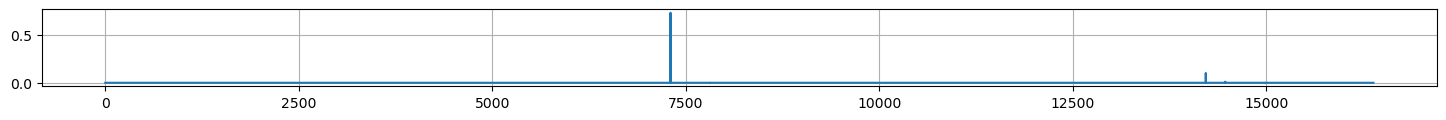

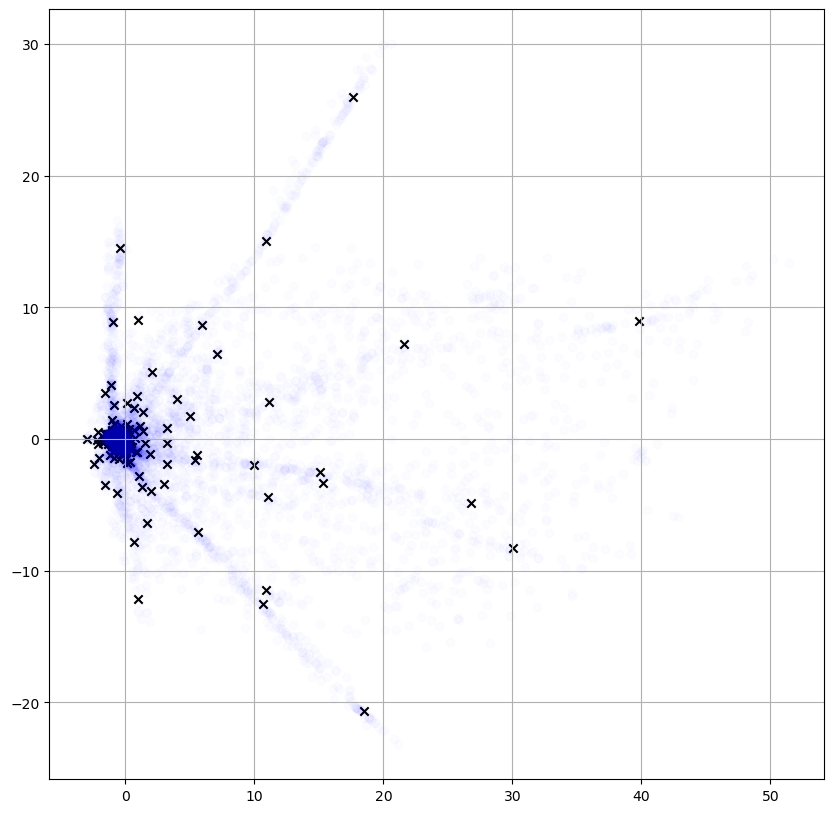

26001
lse_loss -177.3350067138672
commit_loss 0.05130419880151749
recon_loss 0.001465803012251854
26002
lse_loss -178.69577026367188
commit_loss 0.05205322802066803
recon_loss 0.0016945728566497564
26003
lse_loss -179.31455993652344
commit_loss 0.05058698356151581
recon_loss 0.0015884427120909095
26004
lse_loss -180.42807006835938
commit_loss 0.051149629056453705
recon_loss 0.0015772327315062284
26005
lse_loss -178.87161254882812
commit_loss 0.05538289248943329
recon_loss 0.0016121286898851395
26006
lse_loss -179.69944763183594
commit_loss 0.047565020620822906
recon_loss 0.0016548975836485624
26007
lse_loss -179.33314514160156
commit_loss 0.05084577947854996
recon_loss 0.001795304357074201
26008
lse_loss -179.40866088867188
commit_loss 0.048568837344646454
recon_loss 0.0015703970566391945
26009
lse_loss -178.968994140625
commit_loss 0.053611088544130325
recon_loss 0.0017364432569593191
26010
lse_loss -178.9700469970703
commit_loss 0.058716047555208206
recon_loss 0.0018198960460722446
2

lse_loss -180.2273406982422
commit_loss 0.05216497927904129
recon_loss 0.0017654704861342907
26085
lse_loss -179.18077087402344
commit_loss 0.04880952835083008
recon_loss 0.001636727713048458
26086
lse_loss -177.89076232910156
commit_loss 0.06370273232460022
recon_loss 0.0019312715157866478
26087
lse_loss -179.52728271484375
commit_loss 0.06127164140343666
recon_loss 0.001699431799352169
26088
lse_loss -178.2439422607422
commit_loss 0.05258554592728615
recon_loss 0.0017199901631101966
26089
lse_loss -180.1739044189453
commit_loss 0.051071710884571075
recon_loss 0.0016028409590944648
26090
lse_loss -179.95382690429688
commit_loss 0.050848763436079025
recon_loss 0.0017130689229816198
26091
lse_loss -180.00918579101562
commit_loss 0.04902410879731178
recon_loss 0.0018002437427639961
26092
lse_loss -178.20492553710938
commit_loss 0.04899104684591293
recon_loss 0.001882099430076778
26093
lse_loss -179.21368408203125
commit_loss 0.061125483363866806
recon_loss 0.0015924430917948484
26094
lse

26168
lse_loss -179.9087371826172
commit_loss 0.058170221745967865
recon_loss 0.001901121810078621
26169
lse_loss -180.24853515625
commit_loss 0.050736550241708755
recon_loss 0.002256746869534254
26170
lse_loss -179.65969848632812
commit_loss 0.055505841970443726
recon_loss 0.0019040172919631004
26171
lse_loss -181.0199737548828
commit_loss 0.05439794808626175
recon_loss 0.001912740059196949
26172
lse_loss -179.49266052246094
commit_loss 0.06470470130443573
recon_loss 0.0019242524867877364
26173
lse_loss -180.56126403808594
commit_loss 0.04749983549118042
recon_loss 0.001764620654284954
26174
lse_loss -179.5784454345703
commit_loss 0.05463814735412598
recon_loss 0.00172732665669173
26175
lse_loss -180.30030822753906
commit_loss 0.05943743512034416
recon_loss 0.001954839564859867
26176
lse_loss -181.0202178955078
commit_loss 0.055927276611328125
recon_loss 0.0016055339947342873
26177
lse_loss -180.84832763671875
commit_loss 0.05113890394568443
recon_loss 0.001725687994621694
26178
lse_l

26253
lse_loss -180.9332275390625
commit_loss 0.0514775775372982
recon_loss 0.0015710549196228385
26254
lse_loss -181.2678680419922
commit_loss 0.04938291013240814
recon_loss 0.0015946042258292437
26255
lse_loss -180.63870239257812
commit_loss 0.054074883460998535
recon_loss 0.0015800062101334333
26256
lse_loss -180.79676818847656
commit_loss 0.057564876973629
recon_loss 0.0016025826334953308
26257
lse_loss -180.6023712158203
commit_loss 0.0555502325296402
recon_loss 0.00195509335026145
26258
lse_loss -180.3402557373047
commit_loss 0.056121598929166794
recon_loss 0.0015835276572033763
26259
lse_loss -180.9214630126953
commit_loss 0.05528806149959564
recon_loss 0.0016459680628031492
26260
lse_loss -181.17007446289062
commit_loss 0.05476784333586693
recon_loss 0.001760753570124507
26261
lse_loss -181.20448303222656
commit_loss 0.05532006919384003
recon_loss 0.0015822884161025286
26262
lse_loss -180.74746704101562
commit_loss 0.05926642566919327
recon_loss 0.001674013677984476
26263
lse_l

lse_loss -180.5867919921875
commit_loss 0.05170600488781929
recon_loss 0.0018028372433036566
26337
lse_loss -180.9439697265625
commit_loss 0.04756348580121994
recon_loss 0.0015523143811151385
26338
lse_loss -181.24290466308594
commit_loss 0.05290111526846886
recon_loss 0.0017722188495099545
26339
lse_loss -180.90872192382812
commit_loss 0.05688043683767319
recon_loss 0.001749370014294982
26340
lse_loss -181.72532653808594
commit_loss 0.05074092373251915
recon_loss 0.0015844942536205053
26341
lse_loss -181.163330078125
commit_loss 0.049080438911914825
recon_loss 0.0016995234182104468
26342
lse_loss -181.5545654296875
commit_loss 0.04746300354599953
recon_loss 0.0016184014966711402
26343
lse_loss -180.74383544921875
commit_loss 0.05345826596021652
recon_loss 0.0016662338748574257
26344
lse_loss -181.08383178710938
commit_loss 0.05311444401741028
recon_loss 0.0014984449371695518
26345
lse_loss -181.4151153564453
commit_loss 0.05060579255223274
recon_loss 0.0016488649416714907
26346
lse_lo

lse_loss -181.9292755126953
commit_loss 0.055443741381168365
recon_loss 0.0017251083627343178
26421
lse_loss -180.61102294921875
commit_loss 0.05993225425481796
recon_loss 0.0015069380169734359
26422
lse_loss -181.39451599121094
commit_loss 0.05149034410715103
recon_loss 0.0016606696881353855
26423
lse_loss -182.2398223876953
commit_loss 0.05241952836513519
recon_loss 0.0017484554555267096
26424
lse_loss -180.19187927246094
commit_loss 0.054930079728364944
recon_loss 0.001707634306512773
26425
lse_loss -181.86134338378906
commit_loss 0.05234916880726814
recon_loss 0.001683705486357212
26426
lse_loss -181.99392700195312
commit_loss 0.051451753824949265
recon_loss 0.0017321854829788208
26427
lse_loss -181.15330505371094
commit_loss 0.052190884947776794
recon_loss 0.0018218414625152946
26428
lse_loss -181.81338500976562
commit_loss 0.05126374214887619
recon_loss 0.0018991621909663081
26429
lse_loss -182.0825653076172
commit_loss 0.05333087220788002
recon_loss 0.0016366405179724097
26430
l

26503
lse_loss -181.6737060546875
commit_loss 0.05383443459868431
recon_loss 0.0017077428055927157
26504
lse_loss -181.3433837890625
commit_loss 0.0576789453625679
recon_loss 0.0016093701124191284
26505
lse_loss -181.50784301757812
commit_loss 0.05151879042387009
recon_loss 0.0017380013596266508
26506
lse_loss -181.10340881347656
commit_loss 0.05294369161128998
recon_loss 0.0016700143460184336
26507
lse_loss -181.48745727539062
commit_loss 0.05267047882080078
recon_loss 0.0017564573790878057
26508
lse_loss -182.49171447753906
commit_loss 0.05241461843252182
recon_loss 0.001647509983740747
26509
lse_loss -181.76695251464844
commit_loss 0.05562062934041023
recon_loss 0.0016300308052450418
26510
lse_loss -180.89820861816406
commit_loss 0.05269300192594528
recon_loss 0.0016780763398855925
26511
lse_loss -181.71485900878906
commit_loss 0.05266198888421059
recon_loss 0.0017277682200074196
26512
lse_loss -181.6798553466797
commit_loss 0.0514276847243309
recon_loss 0.0017032460309565067
26513


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

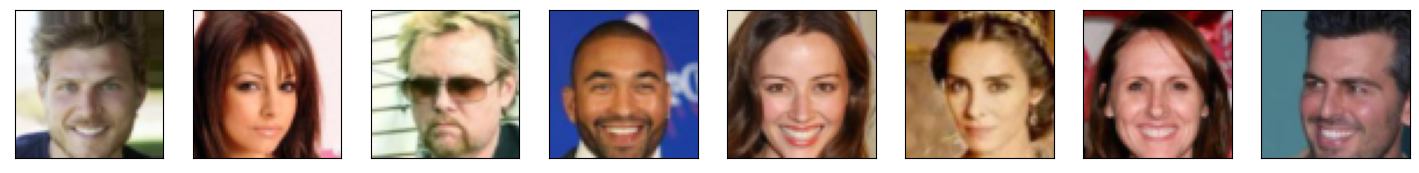

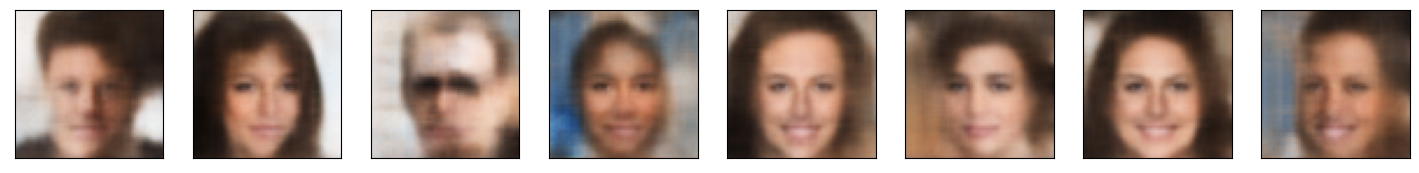

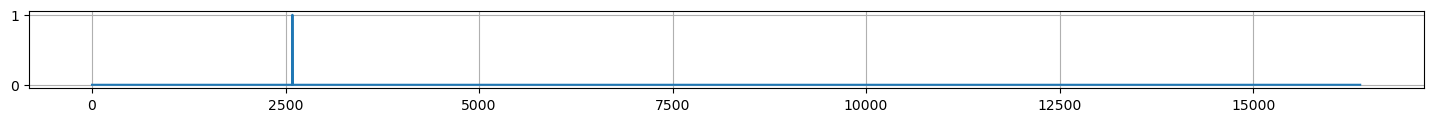

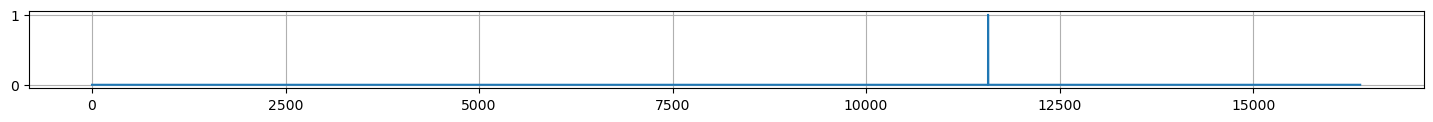

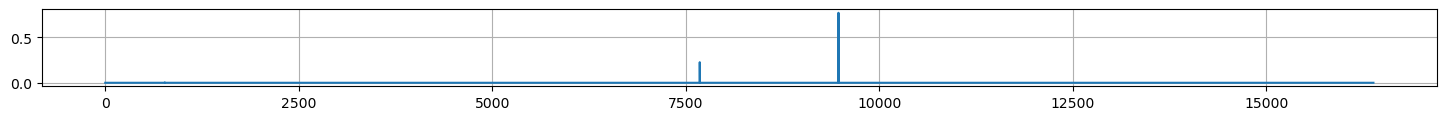

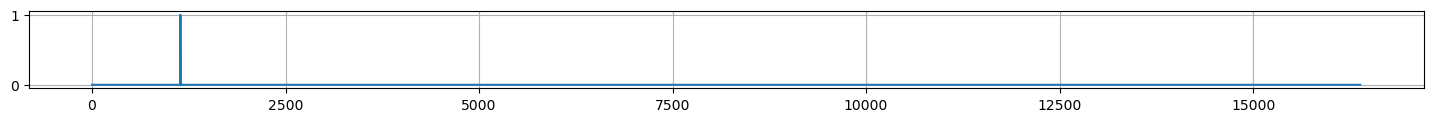

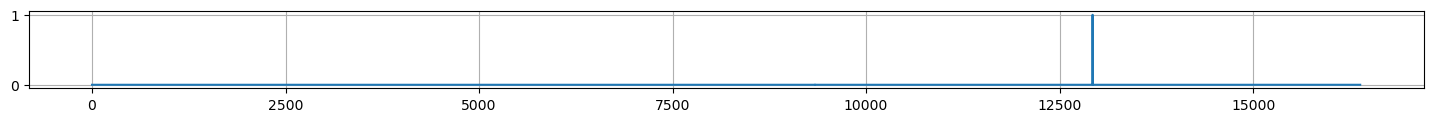

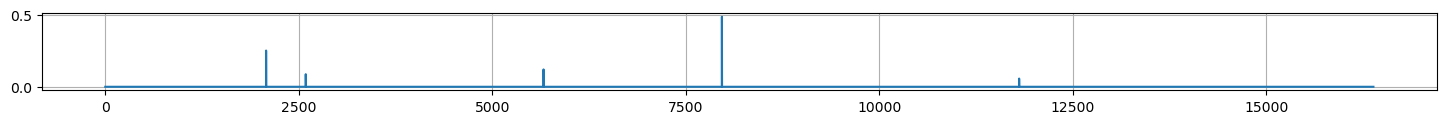

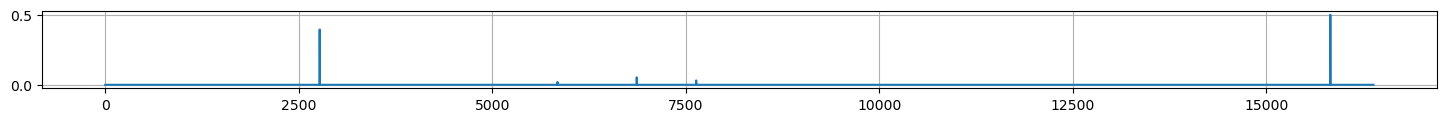

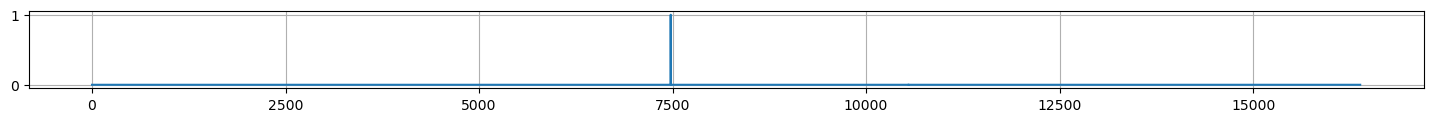

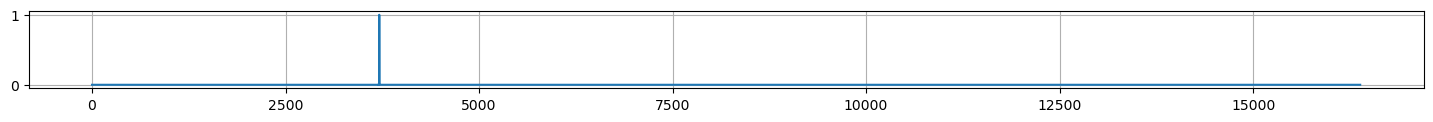

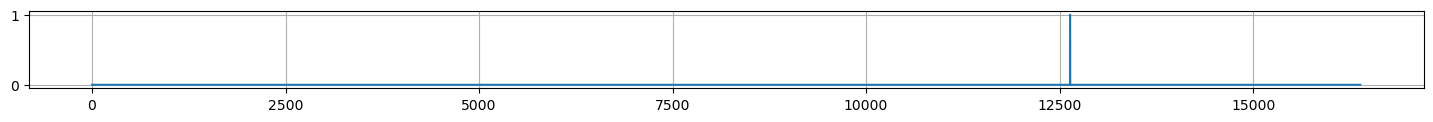

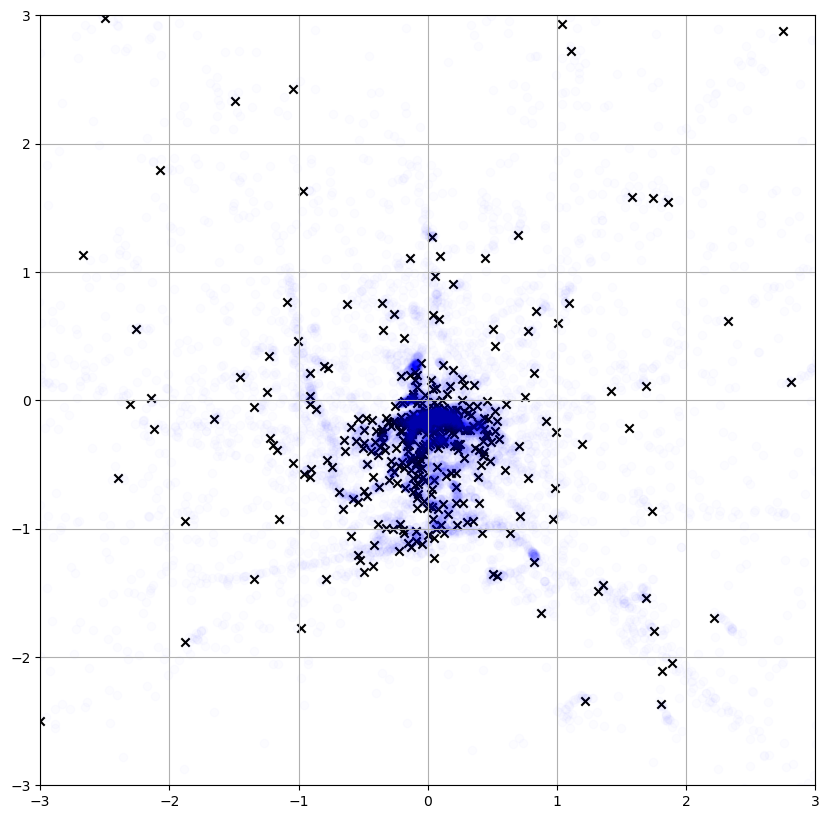

In [23]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.show() 

In [32]:
from tqdm import tqdm

belongs = []
for i, batch in tqdm(enumerate(train_loader)):
    data = preprocess(batch)

    # Forward
    model.eval()
    data = model(data, latent_temp=1)
    belongs.append(data['belong'])

    if i > 2:
        break

3it [00:00, 10.83it/s]


In [33]:
belongs = torch.stack(belongs, dim=0)
print(belongs.shape)

torch.Size([4, 16384, 512])


In [34]:
(belongs.sum(dim=[0, 1]) > 0).sum()

tensor(512, device='cuda:0')